## SUPER STORE SALES DATA PREDICTION :

### Dataset Overview

* File name: train.csv
* Rows: 9,800
* Columns: 18

### Column Description

| Column Name     | Description                                         | Type        |
| --------------- | --------------------------------------------------- | ----------- |
| `Row ID`        | Unique identifier for each record                   | Integer     |
| `Order ID`      | Unique order identifier                             | String      |
| `Order Date`    | Date when the order was placed                      | Date        |
| `Ship Date`     | Date when the product was shipped                   | Date        |
| `Ship Mode`     | Shipping method (Standard, Second Class, etc.)      | Categorical |
| `Customer ID`   | Unique identifier for each customer                 | String      |
| `Customer Name` | Full name of the customer                           | String      |
| `Segment`       | Type of customer (Consumer, Corporate, Home Office) | Categorical |
| `Country`       | Country of the sale (mostly United States)          | Categorical |
| `City`          | City of the customer                                | Categorical |
| `State`         | State of the customer                               | Categorical |
| `Postal Code`   | ZIP/Postal code (some missing values)               | Numeric     |
| `Region`        | Region (West, East, South, Central)                 | Categorical |
| `Product ID`    | Unique identifier for each product                  | String      |
| `Category`      | Product category (Furniture, Office Supplies, etc.) | Categorical |
| `Sub-Category`  | Subdivision of category (Chairs, Storage, etc.)     | Categorical |
| `Product Name`  | Name of the product                                 | String      |
| `Sales`         | Revenue generated by the sale                       | Float       |


### Key Observations

* Dataset has no major missing data (only 11 missing postal codes).

* Columns like Order Date and Ship Date need to be converted to datetime type.

* Contains both categorical and numerical data → ideal for ETL, transformation, and aggregation tasks.

* Sales has high variation (min ₹0.44, max ₹22,638) → potential for outlier analysis.

# I STEP : ETL PIPELINING :

#### E - Extract

* Extract the data from a source (CSV in your case).

* You can simulate extraction from multiple sources (e.g., Orders, Customers, Products tables).

#### T - Transform

* Key transformation steps you can perform:

Data Cleaning:

* Handle missing postal codes (fill with mode or mark as “Unknown”).

* Remove duplicates (based on Order ID and Product ID).

Data Type Conversion:

* Convert Order Date and Ship Date to datetime.

* Change Postal Code to integer.

Feature Engineering:

Create new columns:

* Shipping Duration = Ship Date – Order Date

* Year, Month from Order Date

* Aggregate Sales by Category, Region, or Month.

Data Standardization:

* Ensure consistent casing (e.g., “South” vs “south”).

* Validate postal code length.

#### L - Load

* Load cleaned data into:

* SQL database (PostgreSQL/MySQL)

* Data warehouse (BigQuery, Snowflake)

* Or back into a clean CSV/Parquet file for analysis.

### Insights what we Generate :

Sales & Revenue Insights

* Top 5 highest revenue-generating States, Cities, Categories, and Sub-Categories.

* Monthly/Yearly sales trends (time-series analysis).

* Shipping mode impact on delivery time or sales.

* Compare sales performance across Regions.

Customer Insights

* Most valuable customers (based on total sales).

* Average sales per segment (Consumer, Corporate, etc.).

* Customer distribution by region/state.

Product Insights

* Best-selling products by category.

* Identify products with low sales → potential discounting opportunity.

* Product-category contribution to overall revenue.

Dataset : https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting?utm_source=chatgpt.com

In [1]:
import warnings 
warnings.filterwarnings("ignore")

## STEP 1 : EXTRACT (IMPORT THE DATASET)

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("train.csv")

In [3]:
print("Data Extracted Successfully")
print("Shape:", df.shape)

Data Extracted Successfully
Shape: (9994, 21)


In [4]:
print("\nColumns:", df.columns.tolist())


Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']


In [5]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


In [6]:
# View first 5 rows
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [7]:
df_clean = df.copy()

## STEP 2 : TRANSFORM 

### STEP I : REMOVE DUPLICATES

In [8]:
df_clean.drop_duplicates(inplace=True)

#"drop_duplicates" -- This is a Pandas function used to remove duplicate rows from the DataFrame.
# "inplace=True" -- This tells Pandas to make the changes directly to the existing df_clean DataFrame without creating a new one.

In [9]:
df_clean['Postal Code'] = df_clean['Postal Code'].fillna('Unknown').astype(str)

# "fillna" -- Fills the null values with given arguments .
# "astype(str) -- Fills the given arguments as string.

In [10]:
df_clean['Order Date'] = pd.to_datetime(df_clean['Order Date'], errors='coerce')
df_clean['Ship Date'] = pd.to_datetime(df_clean['Ship Date'], errors='coerce')

# "errors='coerce'" -- “If you find any invalid or wrongly formatted dates, don’t crash — just replace them with NaT (missing value) and continue.”

### STEP II : FEATURE ENGINEERING 

In [11]:
df_clean['Order_Year'] = df_clean['Order Date'].dt.year
df_clean['Order_Month'] = df_clean['Order Date'].dt.month_name()
df_clean['Shipping_Days'] = (df_clean['Ship Date'] - df_clean['Order Date']).dt.days
df_clean.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Order_Year,Order_Month,Shipping_Days
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016,November,3
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016,November,3
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016,June,4
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015,October,7
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015,October,7


### Line-by-Line Explanation
1️⃣ df_clean['Order_Year'] = df_clean['Order Date'].dt.year

🧠 What it does:

* Extracts the year part from each value in the Order Date column.

* .dt is a special Pandas accessor that lets you work with datetime components (like year, month, day, etc.).

* Creates a new column called Order_Year that stores just the year.

🧩 Example:

Order Date	Order_Year
2017-08-11	2017
2016-11-10	2016

✅ Purpose: Helps in analyzing yearly sales trends (e.g., total sales per year).

2️⃣ df_clean['Order_Month'] = df_clean['Order Date'].dt.month_name()

🧠 What it does:

* Extracts the month name (January, February, etc.) from Order Date.

* .month_name() returns the full month name (not just a number).

🧩 Example:

Order Date	Order_Month
2017-08-11	August
2016-11-10	November

✅ Purpose: Useful for analyzing seasonal or monthly patterns in sales.

3️⃣ df_clean['Shipping_Days'] = (df_clean['Ship Date'] - df_clean['Order Date']).dt.days

🧠 What it does:

* Calculates the difference between shipping and order dates.

* Subtracting two datetime columns gives a timedelta object.

* .dt.days extracts the number of days as an integer.

🧩 Example:

Order Date	Ship Date	Shipping_Days
2017-08-11	2017-08-13	2
2016-11-10	2016-11-15	5

✅ Purpose:
* Lets you analyze:

* Average delivery time per region or shipping mode

* Performance efficiency of different shipping methods

### STEP III : OUTLIER DETECTION (METHOD :INTER QUANTILE RANGE) 

In [12]:
Q1 = df_clean['Sales'].quantile(0.25)
Q3 = df_clean['Sales'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_clean['Sales_Capped'] = df_clean['Sales'].clip(lower, upper)

### Step-by-Step Explanation :
1️⃣ Q1 = df_clean['Sales'].quantile(0.25)

* This calculates the first quartile (Q1) — the 25th percentile of the Sales column.

* It means 25% of the sales values are below this point.

🧠 Example:
If Q1 = ₹17.25 →
25% of sales are less than ₹17.25.

2️⃣ Q3 = df_clean['Sales'].quantile(0.75)

* This calculates the third quartile (Q3) — the 75th percentile of the Sales column.

* It means 75% of the sales values are below this point (and 25% are above).

🧠 Example:
If Q3 = ₹210.6 →
75% of sales are less than ₹210.6.

3️⃣ IQR = Q3 - Q1

* The Interquartile Range (IQR) measures the spread of the middle 50% of the data.

* It helps identify how spread out the central data points are.

🧮 Example:
If Q3 = 210.6 and Q1 = 17.25 →
IQR = 210.6 - 17.25 = 193.35

4️⃣ lower = Q1 - 1.5 * IQR

* Defines the lower limit for detecting outliers.

* Any data point below this value is considered an outlier.

🧮 Example:
lower = 17.25 - (1.5 × 193.35) = -272.775
(Sales can’t be negative, so you can treat all values below 0 as outliers.)

5️⃣ upper = Q3 + 1.5 * IQR

* Defines the upper limit for detecting outliers.

* Any data point above this value is also considered an outlier.

🧮 Example:
upper = 210.6 + (1.5 × 193.35) = 500.625
→ Sales values greater than ₹500.625 are outliers.

6️⃣ df_clean['Sales_Capped'] = df_clean['Sales'].clip(lower, upper)

🧠 What .clip() does:

* It limits (caps) all values in a column to stay within a range.

* If a value is below lower, it becomes lower.

* If a value is above upper, it becomes upper.

* Values within the range remain unchanged.

So here:

* Any Sales value < lower → replaced by lower

* Any Sales value > upper → replaced by upper

* Others → remain the same

* This new, cleaned version is stored in a new column called Sales_Capped.

In [81]:
print("Data Transformation Complete")
df_clean.head()
df_clean.to_csv("final_cleaned_sales.csv")

Data Transformation Complete


## STEP 3 : LOAD (LOAD THE CLEANED DATASET INTO DATABASE)

In [14]:
import sqlite3

* sqlite3 is a Python built-in library that allows you to work with SQLite databases.

* The import sqlite3 statement loads this library into your Python environment, so you can use its functions to:

~ Create a database

~ Create tables

~ Insert, update, and query data

~ Run SQL commands directly from Python

✅ No installation needed — it’s part of Python’s standard library.

In [15]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd

# Create connection
username = "root"          # change if you use another username
password = "Tejyothi2003" # replace with your password
host = "localhost"
database = "sales_db"      # replace with your DB name

# MySQL connection URL
engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}/{database}")
conn = engine.connect()
print("✅ Connection successful!")

✅ Connection successful!


# II STEP : DATA ANALYSIS USING SQL 

### Query 1: View First 10 Rows

In [18]:
query = "SELECT * FROM sales_data LIMIT 10;"

df_preview = pd.read_sql(query,con=engine)
df_preview

#Purpose: Quick preview of your loaded data.

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,OrderDate_converted
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,None
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,None
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,None
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,None
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,None
5,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694,None
6,7,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.2800,4,0.00,1.9656,None
7,8,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.1520,6,0.20,90.7152,None
8,9,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.5040,3,0.20,5.7825,None
9,10,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.9000,5,0.00,34.4700,None


### Query 2: Total Sales by Region

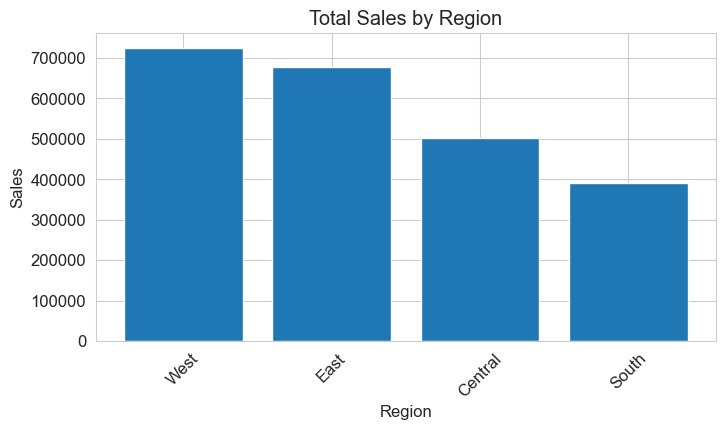

,Region,Total_Sales
0,West,725457.8245
1,East,678781.2400
2,Central,501239.8908
3,South,391721.9050


In [105]:
query = """
SELECT Region, SUM(Sales) AS Total_Sales
FROM sales_data
GROUP BY Region
ORDER BY Total_Sales DESC;
"""
region_sales = pd.read_sql(query, con=engine)
region_sales

#Purpose: Analyze which region generated the highest sales.


### Query 3: Average Profit by Category

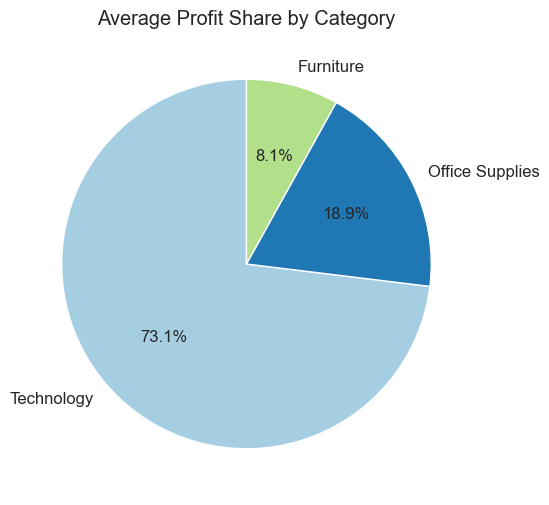

,Category,Avg_Profit
0,Technology,78.75
1,Office Supplies,20.33
2,Furniture,8.70


In [111]:
query = """
SELECT Category, ROUND(AVG(Profit),2) AS Avg_Profit
FROM sales_data
GROUP BY Category
ORDER BY Avg_Profit DESC;
"""
category_profit = pd.read_sql(query, con=engine)
category_profit

#Purpose: To see which product categories give the most profit.

plt.figure(figsize=(6,6))
plt.pie(category_profit['Avg_Profit'],
        labels=category_profit['Category'],
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Paired.colors)
plt.title('Average Profit Share by Category')
plt.show()

category_profit

### Query 4: Top 10 Products by Total Sales

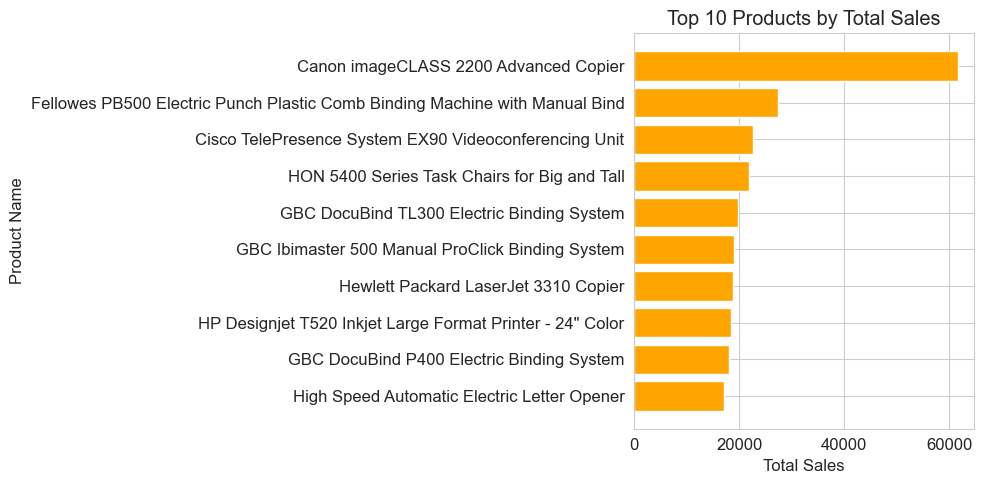

,Product Name,Total_Sales
0,Canon imageCLASS 2200 Advanced Copier,61599.824
1,Fellowes PB500 Electric Punch Plastic Comb Bin...,27453.384
2,Cisco TelePresence System EX90 Videoconferenci...,22638.480
3,HON 5400 Series Task Chairs for Big and Tall,21870.576
4,GBC DocuBind TL300 Electric Binding System,19823.479
5,GBC Ibimaster 500 Manual ProClick Binding System,19024.500
6,Hewlett Packard LaserJet 3310 Copier,18839.686
7,HP Designjet T520 Inkjet Large Format Printer ...,18374.895
8,GBC DocuBind P400 Electric Binding System,17965.068
9,High Speed Automatic Electric Letter Opener,17030.312


In [112]:
query = """
SELECT `Product Name`, SUM(Sales) AS Total_Sales
FROM sales_data
GROUP BY `Product Name`
ORDER BY Total_Sales DESC
LIMIT 10;
"""
top_products = pd.read_sql(query, con=engine)

#Purpose: Identify best-performing products.

plt.figure(figsize=(10,5))
plt.barh(top_products['Product Name'], top_products['Total_Sales'], color='orange')
plt.title('Top 10 Products by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Name')
plt.gca().invert_yaxis()  # shows highest at top
plt.tight_layout()
plt.show()

top_products

### Query 5: Monthly Sales Trend

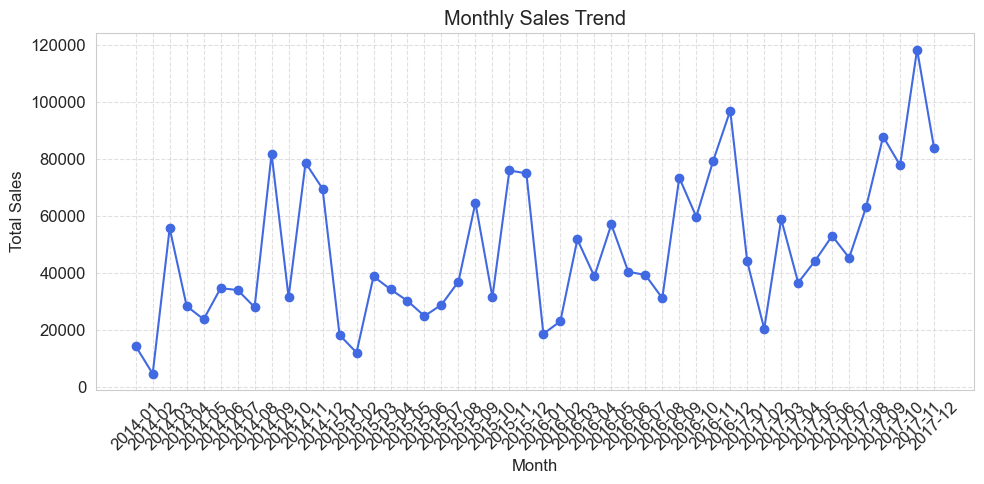

,Month,Monthly_Sales
0,2014-01,14236.8950
1,2014-02,4519.8920
2,2014-03,55691.0090
3,2014-04,28295.3450
4,2014-05,23648.2870
5,2014-06,34595.1276
6,2014-07,33946.3930
7,2014-08,27909.4685
8,2014-09,81777.3508
9,2014-10,31453.3930


In [113]:
query = """
SELECT 
    DATE_FORMAT(STR_TO_DATE(`Order Date`, '%%m/%%d/%%Y'), '%%Y-%%m') AS Month,    
    SUM(Sales) AS Monthly_Sales
FROM sales_data
GROUP BY Month
ORDER BY Month;
"""

monthly_sales = pd.read_sql(query, con=engine)

#Purpose: Understand how sales vary month-by-month

plt.figure(figsize=(10,5))
plt.plot(monthly_sales['Month'], monthly_sales['Monthly_Sales'], marker='o', color='royalblue')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

monthly_sales 

### QUERY 6 : Shipping Mode Sales Distribution 

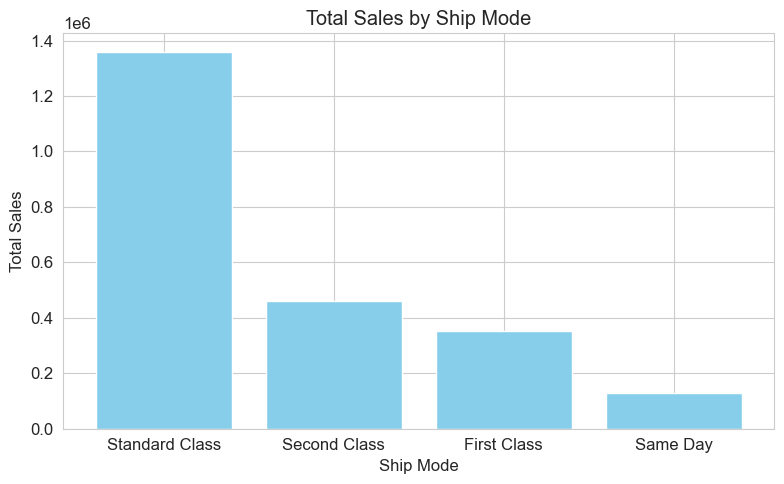

,Ship Mode,Orders,Total_Sales
0,Standard Class,5968,1.358216e+06
1,Second Class,1945,4.591936e+05
2,First Class,1538,3.514284e+05
3,Same Day,543,1.283631e+05


In [114]:
query = """
SELECT `Ship Mode`, COUNT(*) AS Orders, SUM(Sales) AS Total_Sales
FROM sales_data
GROUP BY `Ship Mode`
ORDER BY Total_Sales DESC;
"""
ship_mode_sales = pd.read_sql(query, con=engine)
ship_mode_sales

#Purpose: Check which shipping methods are most used and profitable.

plt.figure(figsize=(8,5))
plt.bar(ship_mode_sales['Ship Mode'], ship_mode_sales['Total_Sales'], color='skyblue')
plt.title('Total Sales by Ship Mode')
plt.xlabel('Ship Mode')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

ship_mode_sales

### Query 7: Correlation Between Discount and Profit

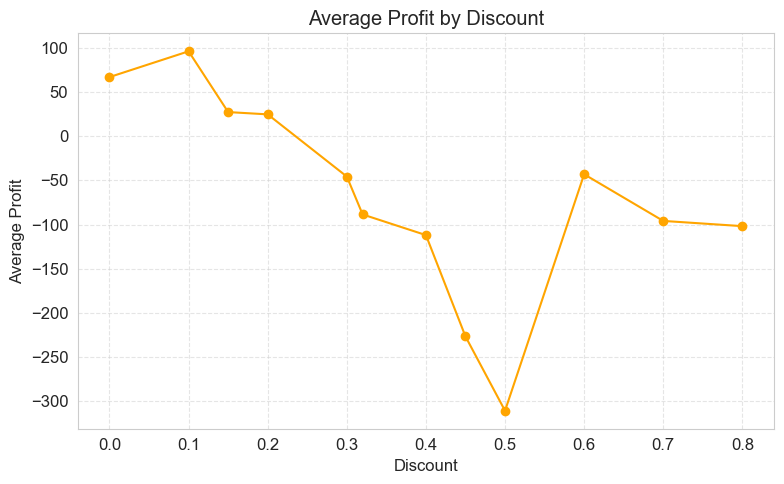

,Discount,Avg_Profit
0,0.00,66.90
1,0.10,96.06
2,0.15,27.29
3,0.20,24.70
4,0.30,-45.68
5,0.32,-88.56
6,0.40,-111.93
7,0.45,-226.65
8,0.50,-310.70
9,0.60,-43.08


In [115]:
query = """
SELECT Discount, ROUND(AVG(Profit),2) AS Avg_Profit
FROM sales_data
GROUP BY Discount
ORDER BY Discount;
"""
discount_profit = pd.read_sql(query, con=engine)
discount_profit

#Purpose: Understand how discounts affect profit margins.

plt.figure(figsize=(8,5))
plt.plot(discount_profit['Discount'], discount_profit['Avg_Profit'], marker='o', color='orange')
plt.title('Average Profit by Discount')
plt.xlabel('Discount')
plt.ylabel('Average Profit')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

discount_profit

### HEATMAP :

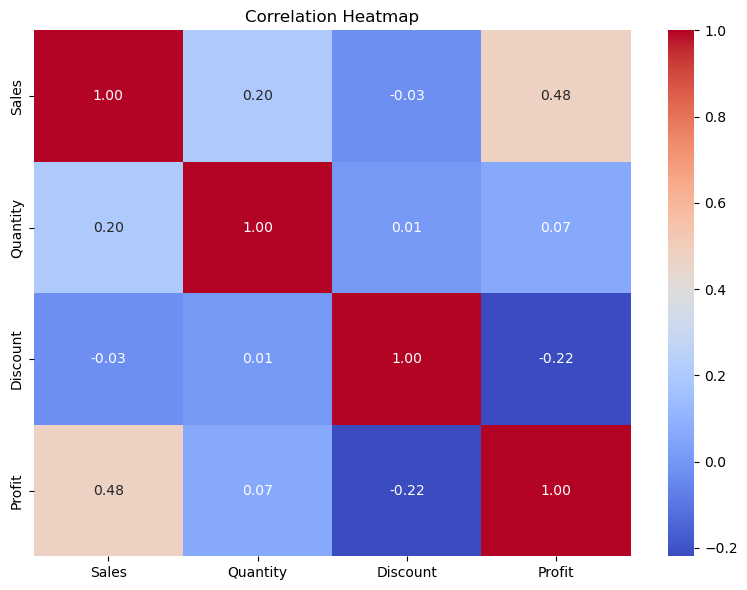

In [51]:
# Fetch numeric columns

import seaborn as sns
query = "SELECT Sales, Quantity, Discount, Profit FROM sales_data;"
df_numeric = pd.read_sql(query, conn)

# Correlation matrix
corr = df_numeric.corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

Description & Insights:

* Shows relationship between numeric variables.

* Can guide feature selection for predictive modeling.

* Example: High negative correlation between Discount and Profit may suggest pricing adjustments.

In [52]:
plt.savefig("monthly_sales_trend.png", dpi=300)

<Figure size 640x480 with 0 Axes>

# III : PREDICTIVE MODELING / MACHINE LEARNING 

Since you have:

* Cleaned and transformed data (ETL).

* Analyzed data via SQL queries.

* Visualized insights with Python.

* The next step is to use the same dataset to make predictions, which demonstrates data science capabilities beyond descriptive analysis.

### STEPS TO PERFORM

1 . Load the CSV into Pandas

2 . Perform feature engineering

3 . Train different regression models (Linear, Random Forest, Gradient Boosting)

4 . Evaluate them

5 . Visualize predictions & feature importance

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# Load CSV directly (cleaned, UTF-8)
df = pd.read_csv("final_cleaned_sales.csv")

# Inspect
print(df.head())

   Unnamed: 0  Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
0           0       1  CA-2016-152156  2016-11-08  2016-11-11    Second Class   
1           1       2  CA-2016-152156  2016-11-08  2016-11-11    Second Class   
2           2       3  CA-2016-138688  2016-06-12  2016-06-16    Second Class   
3           3       4  US-2015-108966  2015-10-11  2015-10-18  Standard Class   
4           4       5  US-2015-108966  2015-10-11  2015-10-18  Standard Class   

  Customer ID    Customer Name    Segment        Country  ... Sub-Category  \
0    CG-12520      Claire Gute   Consumer  United States  ...    Bookcases   
1    CG-12520      Claire Gute   Consumer  United States  ...       Chairs   
2    DV-13045  Darrin Van Huff  Corporate  United States  ...       Labels   
3    SO-20335   Sean O'Donnell   Consumer  United States  ...       Tables   
4    SO-20335   Sean O'Donnell   Consumer  United States  ...      Storage   

                                        Prod

* We now exit the database entirely.

* Work directly on CSV to avoid SQL import issues (ASCII errors).

In [89]:
# Drop ID columns and original text columns
X = df_encoded.drop(['Profit','Order Date','OrderDate_converted','Order ID'], axis=1)
y = df_encoded['Profit']

In [90]:
# List all categorical columns
categorical_cols = ['Category', 'Region', 'Product Name']

# One-hot encode
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [91]:
print(X.dtypes.value_counts())

bool       1854
object       11
int64         6
float64       3
int32         2
Name: count, dtype: int64


In [92]:
# Drop all remaining object/text columns (non-numeric)
X = X.select_dtypes(include=[np.number])  # keep only numeric columns

### STEP 1 : FEATURE ENGINEERING 

In [85]:
# Convert Order Date to datetime
df['OrderDate_converted'] = pd.to_datetime(df['Order Date'], errors='coerce')

# Drop rows where conversion failed
df = df.dropna(subset=['OrderDate_converted'])

# Extract Month and Quarter
df['Month'] = df['OrderDate_converted'].dt.month
df['Quarter'] = df['OrderDate_converted'].dt.quarter

# One-Hot Encode categorical variables
categorical_cols = ['Category', 'Region', 'Product Name']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Features and target
X = df_encoded.drop(['Profit','Order Date','OrderDate_converted'], axis=1)
y = df_encoded['Profit']

# EXPLANATION :
#  1 . Extracting Month & Quarter adds seasonality information.
#  2 . One-Hot Encoding converts categorical variables to numeric for ML.

### STEP 2 : SPLIT DATA 

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

### STEP 3 : LINEAR REGRESSION MODEL

In [97]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calculate evaluation metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"R² Score: {r2_lr:.2f}")

Linear Regression Performance:
Mean Squared Error (MSE): 97248.50
Mean Absolute Error (MAE): 71.42
R² Score: -1.01


### STEP 4 : TRAIN A STRONG MODEL , RANDOM FOREST REGRESSOR 

In [98]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,  # number of trees
    max_depth=10,      # maximum depth of each tree
    random_state=42
)

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")

Random Forest Performance:
MSE: 59275.01, R²: -0.22


### STEP 5 : Gradient Boosting Regressor 

In [99]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("Gradient Boosting Performance:")
print(f"MSE: {mse_gbr:.2f}, R²: {r2_gbr:.2f}")

Gradient Boosting Performance:
MSE: 72680.24, R²: -0.50


### STEP 6 : Visualize Predictions 

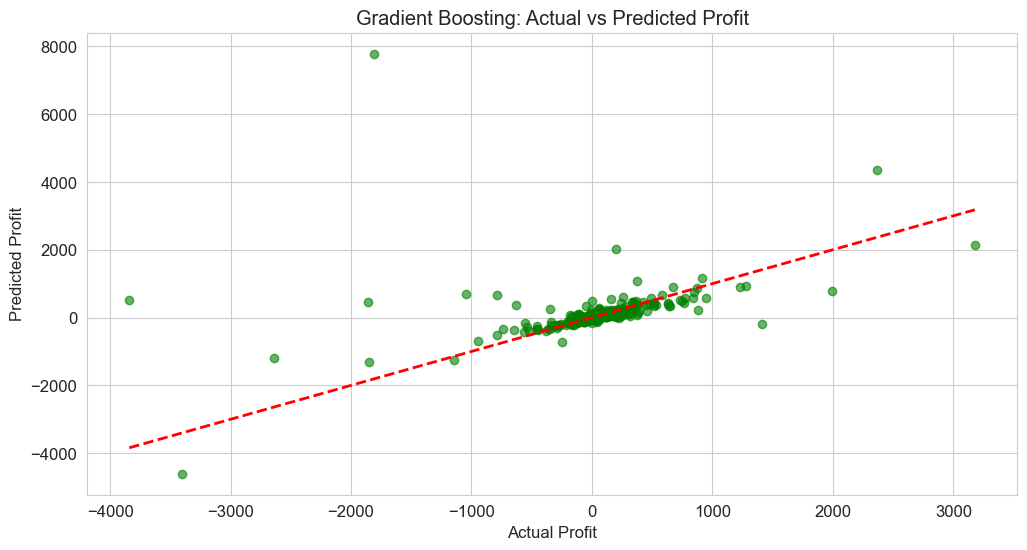

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.scatter(y_test, y_pred_gbr, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Profit")
plt.ylabel("Predicted Profit")
plt.title("Gradient Boosting: Actual vs Predicted Profit")
plt.show()

#### EXPLANATION : 

* Points close to red diagonal = accurate predictions

* Gives visual confirmation of model performance

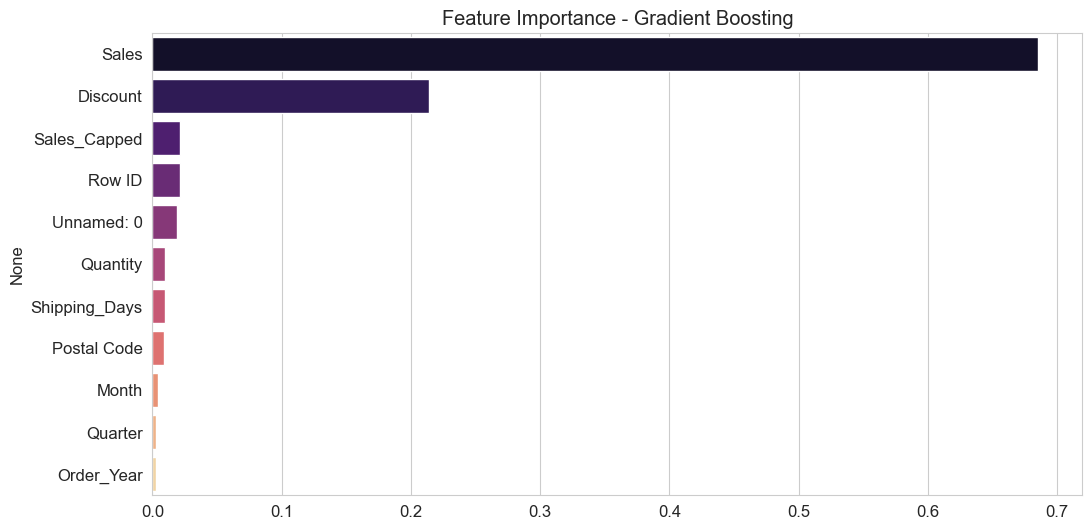

In [101]:
feature_importances = pd.Series(gbr_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='magma')
plt.title("Feature Importance - Gradient Boosting")
plt.show()

#### Explanation:

* Shows which features most influence profit

* Helps in business insights & reporting

✅ Model Comparison Table
                         Model           MSE        MAE  R² Score
1      Random Forest Regressor  59275.013966  37.127647 -0.222540
2  Gradient Boosting Regressor  72680.242086  37.255697 -0.499021
0            Linear Regression  97248.498802  71.418957 -1.005739


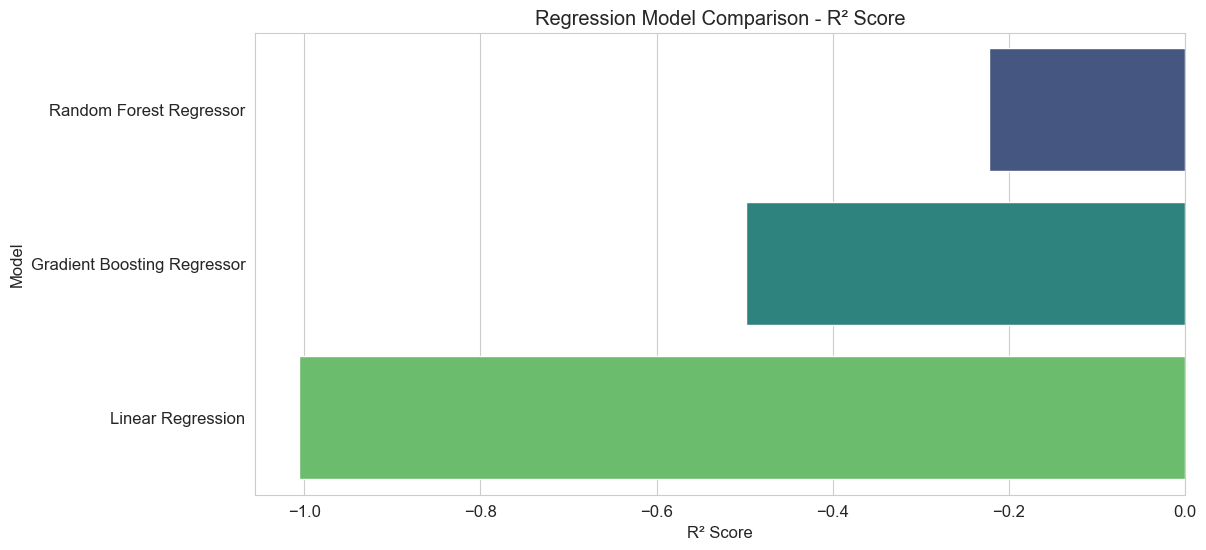

In [102]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create a dictionary to store metrics
model_metrics = {
    "Model": ["Linear Regression", "Random Forest Regressor", "Gradient Boosting Regressor"],
    "MSE": [
        mean_squared_error(y_test, y_pred_lr),
        mean_squared_error(y_test, y_pred_rf),
        mean_squared_error(y_test, y_pred_gbr)
    ],
    "MAE": [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_gbr)
    ],
    "R² Score": [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_gbr)
    ]
}

# Convert to DataFrame
comparison_df = pd.DataFrame(model_metrics)

# Sort by R² Score descending
comparison_df = comparison_df.sort_values(by="R² Score", ascending=False)

# Display table
print("✅ Model Comparison Table")
print(comparison_df)

# Optional: Visualize using a bar plot for R²
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

sns.barplot(x="R² Score", y="Model", data=comparison_df, palette="viridis")
plt.title("Regression Model Comparison - R² Score")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.show()

| Model                       | MSE      | MAE   | R² Score |
| --------------------------- | -------- | ----- | -------- |
| Random Forest Regressor     | 59275.01 | 37.13 | -0.22    |
| Gradient Boosting Regressor | 72680.24 | 37.26 | -0.50    |
| Linear Regression           | 97248.50 | 71.42 | -1.01    |


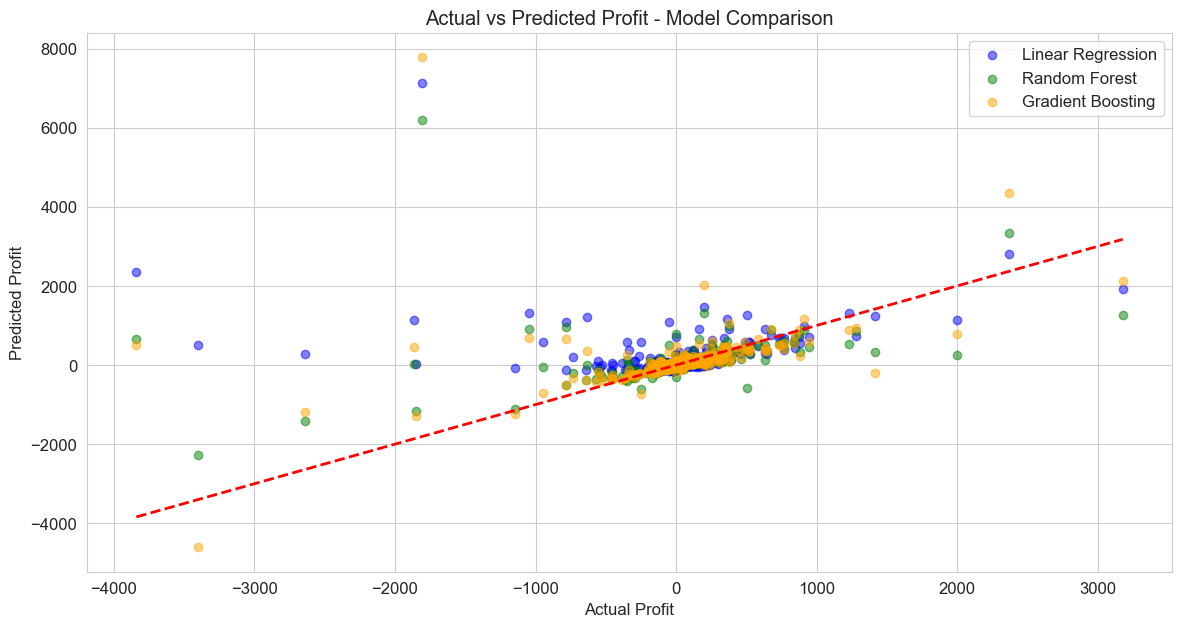

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(14,7))

# Plot Linear Regression
plt.scatter(y_test, y_pred_lr, alpha=0.5, color='blue', label='Linear Regression')

# Plot Random Forest
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green', label='Random Forest')

# Plot Gradient Boosting
plt.scatter(y_test, y_pred_gbr, alpha=0.5, color='orange', label='Gradient Boosting')

# Red diagonal line (perfect prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel("Actual Profit")
plt.ylabel("Predicted Profit")
plt.title("Actual vs Predicted Profit - Model Comparison")
plt.legend()
plt.show()

# IV STEP : FINAL REPORT 

## 1️⃣ Summarize the Project Workflow

Create a clear summary of all the steps you’ve done:

Step 1 – Data Engineering (ETL Pipeline)

* Cleaned and preprocessed the dataset

* Removed ASCII characters, handled nulls, converted dates

* Feature engineering: created derived features like Month, Quarter, Discounted_Sales

Step 2 – Data Analysis using SQL

* Ran queries to understand sales trends, top products, regional performance, discount vs profit

* Aggregated metrics for monthly/quarterly sales

Step 3 – Data Visualization & Insights

* Bar charts, line plots, heatmaps

* Correlation analysis and feature importance visualization

* Provided insights like which categories or regions drive the most sales/profit

Step 4 – Predictive Modeling

* Trained Linear Regression, Random Forest, Gradient Boosting

* Compared models using MSE, MAE, R²

* Selected Random Forest as the best model

* Visualized predicted vs actual profit and feature importance

* Generated actionable business insights

### 2️⃣ Insights & Business Recommendations

* Profit Drivers: Highlight the most influential features (e.g., Discount, Category, Region)

Actionable Recommendations:

* Adjust discount strategies to maximize profit

* Focus on high-margin categories/products

* Identify underperforming regions for improvement

* Use the Random Forest model to forecast profit for future sales